In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Define Models
class LargeModel(nn.Module):
    def __init__(self):
        super(LargeModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1600)  # Increased hidden units
        self.fc2 = nn.Linear(1600, 1600)  # Increased hidden units
        self.fc3 = nn.Linear(1600, 10)
        self.dropout = nn.Dropout2d(0.5)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

class DistilModel(nn.Module):
    def __init__(self):
        super(DistilModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)  # Increased hidden units slightly
        self.fc2 = nn.Linear(800, 800)  # Increased hidden units slightly
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [13]:
# Train Large Model
def train_large(model, train_loader, optimizer, epochs, device):
    model.train()
    loss_arr = []

    for e in range(epochs):
        epoch_loss = 0
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_arr.append(epoch_loss)
        print(f'Epoch {e+1}/{epochs}, Loss: {epoch_loss:.4f}')

    plt.plot(loss_arr)
    plt.title('Training Loss - Large Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Train Distil Model
def train_distil(large_model, distil_model, train_loader, optimizer, loss_fn, device, epochs=10, temp=20, distil_weight=0.7):
    large_model.eval()
    distil_model.train()
    loss_arr = []

    for e in range(epochs):
        epoch_loss = 0
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                soft_label = F.softmax(large_model(data) / temp, dim=1)

            out = distil_model(data)
            soft_out = F.softmax(out / temp, dim=1)

            loss = (1 - distil_weight) * F.cross_entropy(out, label) + distil_weight * loss_fn(soft_out, soft_label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_arr.append(epoch_loss)
        print(f'Epoch {e+1}/{epochs}, Loss: {epoch_loss:.4f}')

    plt.plot(loss_arr)
    plt.title('Training Loss - Distil Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [14]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = len(data_loader.dataset)

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f} ({correct}/{total})')
    return accuracy

In [15]:
def grid_search_hyperparams(train_loader, test_loader, param_grid):
    best_params = None
    best_accuracy = 0.0

    for params in ParameterGrid(param_grid):
        print(f"Testing with parameters: {params}")

        large_model = LargeModel().to(device)
        optimizer_large = optim.SGD(large_model.parameters(), lr=params['lr'], momentum=params['momentum'])

        print("Training Large Model...")
        train_large(large_model, train_loader, optimizer_large, params['epochs'], device)

        accuracy = evaluate(large_model, test_loader, device)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    print(f"Best Parameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    return best_params, best_accuracy

In [16]:
def main():
    batch_size = 100

    # Loading MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'lr': [0.01, 0.05],
        'momentum': [0.9, 0.95],
        'epochs': [10, 15],
    }

    print("Starting Grid Search for Large Model...")
    best_params, best_accuracy = grid_search_hyperparams(train_loader, test_loader, param_grid)

    # Train Distil Model with best parameters found
    large_model = LargeModel().to(device)
    optimizer_large = optim.SGD(large_model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'])
    print("Training Large Model with Best Parameters...")
    train_large(large_model, train_loader, optimizer_large, best_params['epochs'], device)

    print("Evaluating Large Model with Best Parameters...")
    evaluate(large_model, test_loader, device)

    distil_model = DistilModel().to(device)
    optimizer_distil = optim.SGD(distil_model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'])
    loss_fn = nn.KLDivLoss(reduction='batchmean')

    print("Training Distil Model...")
    train_distil(
        large_model=large_model,
        distil_model=distil_model,
        train_loader=train_loader,
        optimizer=optimizer_distil,
        loss_fn=loss_fn,
        device=device,
        epochs=best_params['epochs'],
        temp=20,
        distil_weight=0.7
    )

    print("Evaluating Distil Model...")
    evaluate(distil_model, test_loader, device)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5443758.75it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159763.67it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1513954.25it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6553329.47it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Starting Grid Search for Large Model...
Testing with parameters: {'epochs': 10, 'lr': 0.01, 'momentum': 0.9}
Training Large Model...
Epoch 1/10, Loss: 225.6353
Epoch 2/10, Loss: 91.4198
Epoch 3/10, Loss: 66.4809
Epoch 4/10, Loss: 53.7094
Epoch 5/10, Loss: 42.8722
Epoch 6/10, Loss: 36.7779
Epoch 7/10, Loss: 31.9879
Epoch 8/10, Loss: 27.2841
Epoch 9/10, Loss: 25.1798
Epoch 10/10, Loss: 22.8612


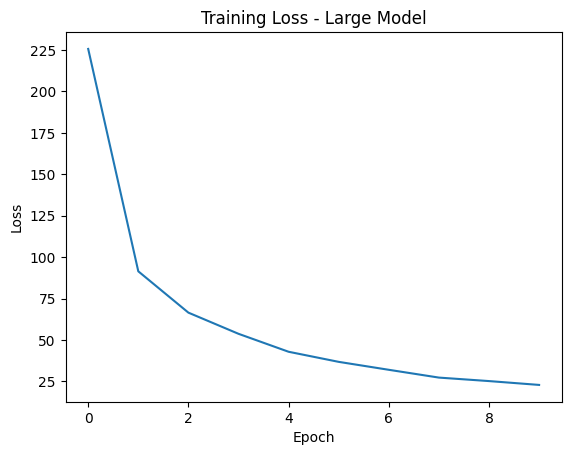

Accuracy: 0.9824 (9824/10000)
Testing with parameters: {'epochs': 10, 'lr': 0.01, 'momentum': 0.95}
Training Large Model...
Epoch 1/10, Loss: 201.5399
Epoch 2/10, Loss: 77.2576
Epoch 3/10, Loss: 58.8005
Epoch 4/10, Loss: 47.9888
Epoch 5/10, Loss: 41.2033
Epoch 6/10, Loss: 33.1720
Epoch 7/10, Loss: 32.0677
Epoch 8/10, Loss: 27.1816
Epoch 9/10, Loss: 24.9591
Epoch 10/10, Loss: 21.2360


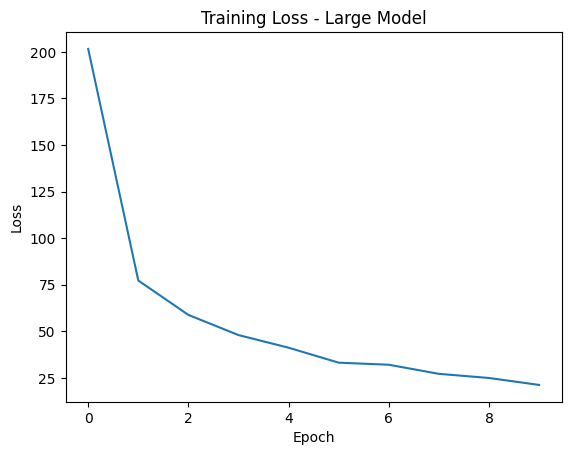

Accuracy: 0.9830 (9830/10000)
Testing with parameters: {'epochs': 10, 'lr': 0.05, 'momentum': 0.9}
Training Large Model...
Epoch 1/10, Loss: 191.1625
Epoch 2/10, Loss: 99.1700
Epoch 3/10, Loss: 81.8696
Epoch 4/10, Loss: 71.1117
Epoch 5/10, Loss: 67.6110
Epoch 6/10, Loss: 60.1256
Epoch 7/10, Loss: 55.4834
Epoch 8/10, Loss: 53.7335
Epoch 9/10, Loss: 50.5075
Epoch 10/10, Loss: 52.6652


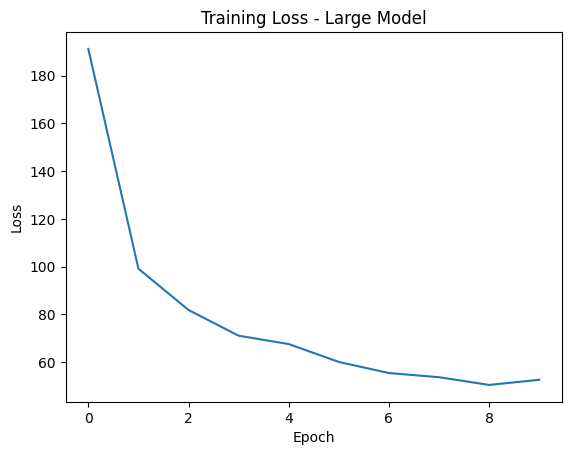

Accuracy: 0.9801 (9801/10000)
Testing with parameters: {'epochs': 10, 'lr': 0.05, 'momentum': 0.95}
Training Large Model...
Epoch 1/10, Loss: 379.1657
Epoch 2/10, Loss: 669.3715
Epoch 3/10, Loss: 941.2482
Epoch 4/10, Loss: 911.8052
Epoch 5/10, Loss: 982.0525
Epoch 6/10, Loss: 1049.0712
Epoch 7/10, Loss: 1107.2264
Epoch 8/10, Loss: 1104.7311
Epoch 9/10, Loss: 1130.9878
Epoch 10/10, Loss: 1143.6877


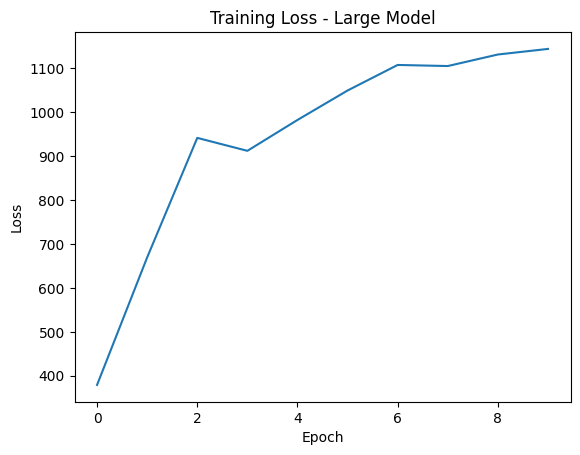

Accuracy: 0.4561 (4561/10000)
Testing with parameters: {'epochs': 15, 'lr': 0.01, 'momentum': 0.9}
Training Large Model...
Epoch 1/15, Loss: 226.0720
Epoch 2/15, Loss: 91.9306
Epoch 3/15, Loss: 66.8976
Epoch 4/15, Loss: 52.5166
Epoch 5/15, Loss: 44.9535
Epoch 6/15, Loss: 37.5699
Epoch 7/15, Loss: 32.7180
Epoch 8/15, Loss: 29.1361
Epoch 9/15, Loss: 25.7288
Epoch 10/15, Loss: 21.9248
Epoch 11/15, Loss: 20.6685
Epoch 12/15, Loss: 18.2673
Epoch 13/15, Loss: 15.2653
Epoch 14/15, Loss: 14.5346
Epoch 15/15, Loss: 14.0839


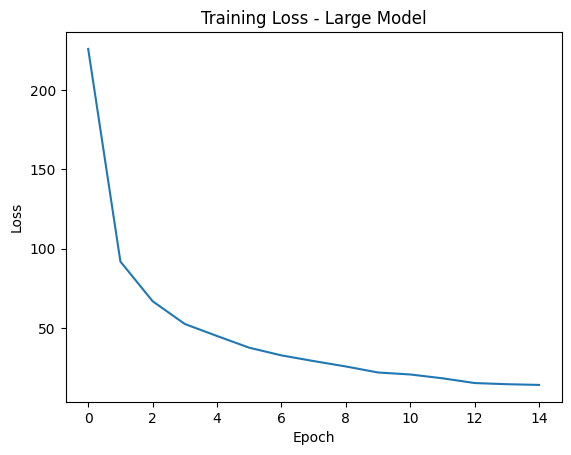

Accuracy: 0.9841 (9841/10000)
Testing with parameters: {'epochs': 15, 'lr': 0.01, 'momentum': 0.95}
Training Large Model...
Epoch 1/15, Loss: 199.4970
Epoch 2/15, Loss: 78.9625
Epoch 3/15, Loss: 59.0697
Epoch 4/15, Loss: 47.5227
Epoch 5/15, Loss: 39.4361
Epoch 6/15, Loss: 33.9588
Epoch 7/15, Loss: 30.6367
Epoch 8/15, Loss: 26.7644
Epoch 9/15, Loss: 23.2044
Epoch 10/15, Loss: 21.8109
Epoch 11/15, Loss: 19.5004
Epoch 12/15, Loss: 18.4336
Epoch 13/15, Loss: 16.5778
Epoch 14/15, Loss: 15.6184
Epoch 15/15, Loss: 15.0148


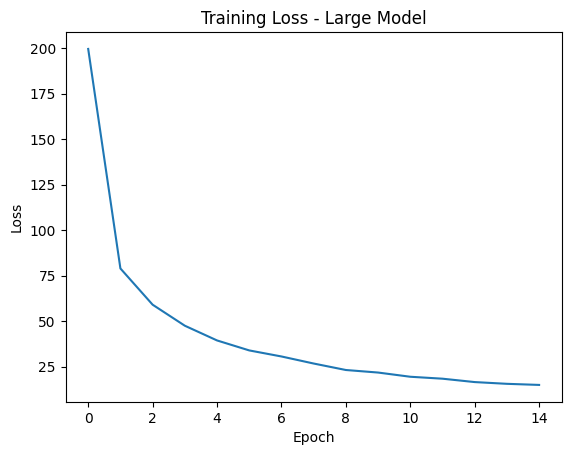

Accuracy: 0.9846 (9846/10000)
Testing with parameters: {'epochs': 15, 'lr': 0.05, 'momentum': 0.9}
Training Large Model...
Epoch 1/15, Loss: 189.1223
Epoch 2/15, Loss: 99.3069
Epoch 3/15, Loss: 83.3594
Epoch 4/15, Loss: 71.2372
Epoch 5/15, Loss: 63.9746
Epoch 6/15, Loss: 58.7244
Epoch 7/15, Loss: 54.5071
Epoch 8/15, Loss: 49.7629
Epoch 9/15, Loss: 51.8307
Epoch 10/15, Loss: 49.8228
Epoch 11/15, Loss: 47.2579
Epoch 12/15, Loss: 47.4351
Epoch 13/15, Loss: 49.6108
Epoch 14/15, Loss: 50.9636
Epoch 15/15, Loss: 45.0874


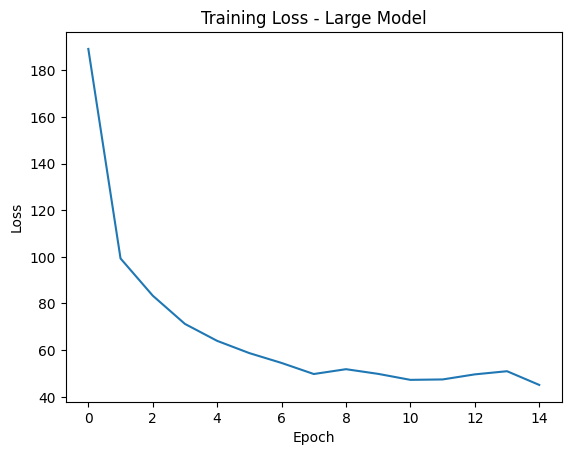

Accuracy: 0.9804 (9804/10000)
Testing with parameters: {'epochs': 15, 'lr': 0.05, 'momentum': 0.95}
Training Large Model...
Epoch 1/15, Loss: 402.3193
Epoch 2/15, Loss: 687.1393
Epoch 3/15, Loss: 870.4863
Epoch 4/15, Loss: 975.5966
Epoch 5/15, Loss: 930.8963
Epoch 6/15, Loss: 996.5336
Epoch 7/15, Loss: 1028.8116
Epoch 8/15, Loss: 1093.7335
Epoch 9/15, Loss: 1108.7472
Epoch 10/15, Loss: 1090.1723
Epoch 11/15, Loss: 1189.3414
Epoch 12/15, Loss: 1238.1549
Epoch 13/15, Loss: 1210.7281
Epoch 14/15, Loss: 1192.0599
Epoch 15/15, Loss: 1193.8251


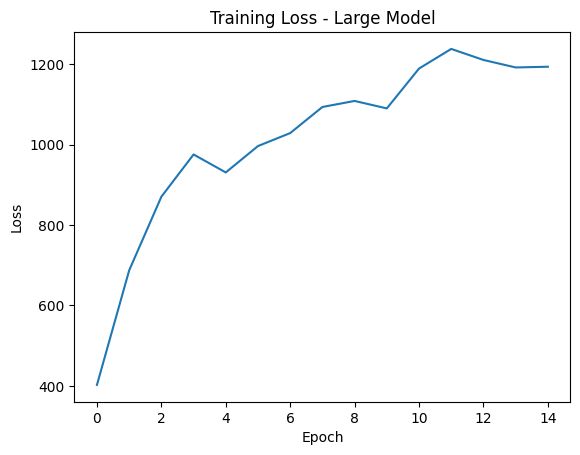

Accuracy: 0.3043 (3043/10000)
Best Parameters: {'epochs': 15, 'lr': 0.01, 'momentum': 0.95}
Best Accuracy: 0.9846
Training Large Model with Best Parameters...
Epoch 1/15, Loss: 201.7249
Epoch 2/15, Loss: 78.5831
Epoch 3/15, Loss: 58.0984
Epoch 4/15, Loss: 47.8177
Epoch 5/15, Loss: 39.8047
Epoch 6/15, Loss: 35.5919
Epoch 7/15, Loss: 29.2248
Epoch 8/15, Loss: 27.6199
Epoch 9/15, Loss: 24.7600
Epoch 10/15, Loss: 21.5399
Epoch 11/15, Loss: 20.3856
Epoch 13/15, Loss: 17.2191
Epoch 14/15, Loss: 15.9264
Epoch 15/15, Loss: 13.8303


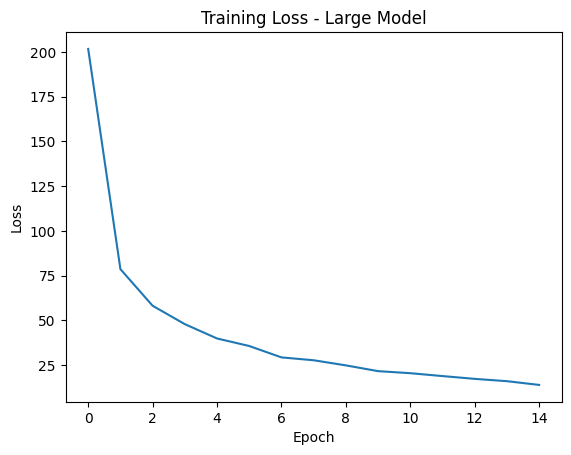

Evaluating Large Model with Best Parameters...
Accuracy: 0.9851 (9851/10000)
Training Distil Model...
Epoch 1/15, Loss: -875.6123
Epoch 2/15, Loss: -927.9662
Epoch 3/15, Loss: -938.7747
Epoch 4/15, Loss: -945.6283
Epoch 5/15, Loss: -950.9829
Epoch 6/15, Loss: -956.8056
Epoch 7/15, Loss: -962.6242
Epoch 8/15, Loss: -968.7154
Epoch 9/15, Loss: -973.9798
Epoch 10/15, Loss: -979.4792
Epoch 11/15, Loss: -983.5872
Epoch 12/15, Loss: -988.2030
Epoch 13/15, Loss: -992.8531
Epoch 14/15, Loss: -997.1500
Epoch 15/15, Loss: -999.6076


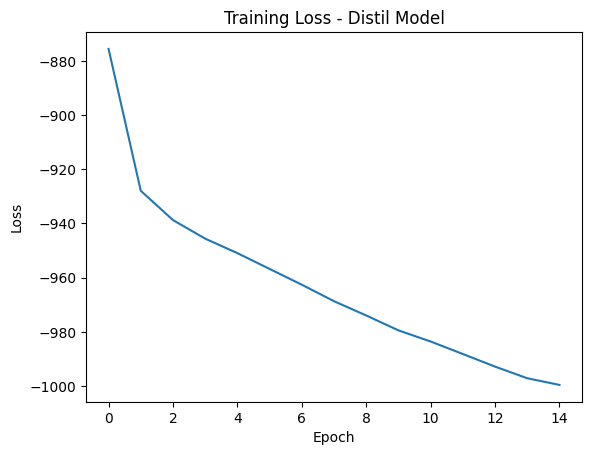

Evaluating Distil Model...
Accuracy: 0.9759 (9759/10000)


In [17]:
# Run the main function
if __name__ == '__main__':
    main()